# Exploratory Analysis

This notebook contains all steps taken in the exploratory analysis phase of the data science pipeline for the Zillow clustering project. This notebook does rely on helper files so if you want to run the code blocks in this notebook ensure that you have all the helper files in the same directory.

---

## The Required Imports

As stated before this notebook relies on some helper files which are imported below. This notebook also relies on numpy, pandas, matplotlib, seaborn, and sklearn.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split

from acquire import AcquireZillow
from prepare import prepare_zillow
from preprocessing import *
from univariate_analysis import *
from bivariate_analysis import *

---

## Acquire and Prepare the Data

Let's acquire, prepare, and split the data before we begin.

In [2]:
# Let's acquire and prepare the data.
zillow = prepare_zillow(AcquireZillow().get_data())
zillow.shape

/Users/whoami/codeup-data-science/methodologies/methodologies1/zillow-clustering-project/_acquire.py:81: DtypeWarning: Columns (64) have mixed types.Specify dtype option on import or set low_memory=False.
  df = self.load_data(use_cache, cache_data)


(62263, 26)

In [3]:
# Now let's split the data.
train, validate, test = split_data(zillow)

## Univariate Analysis

Let's start by exploring the distributions of each feature.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34867 entries, 68462 to 5796
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   34867 non-null  float64
 1   bedroomcnt                    34867 non-null  float64
 2   calculatedbathnbr             34867 non-null  float64
 3   calculatedfinishedsquarefeet  34867 non-null  float64
 4   finishedsquarefeet12          34867 non-null  float64
 5   fips                          34867 non-null  float64
 6   fullbathcnt                   34867 non-null  float64
 7   latitude                      34867 non-null  float64
 8   longitude                     34867 non-null  float64
 9   lotsizesquarefeet             34867 non-null  float64
 10  propertycountylandusecode     34867 non-null  object 
 11  rawcensustractandblock        34867 non-null  float64
 12  regionidcity                  34867 non-null  float64
 13

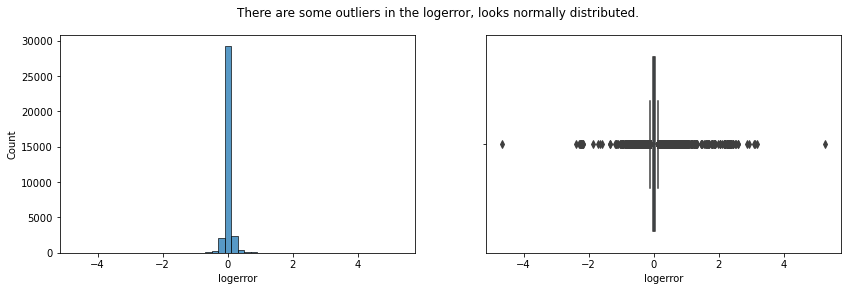

In [5]:
plot_single_variable(train, 'logerror', title = 'There are some outliers in the logerror, looks normally distributed.')

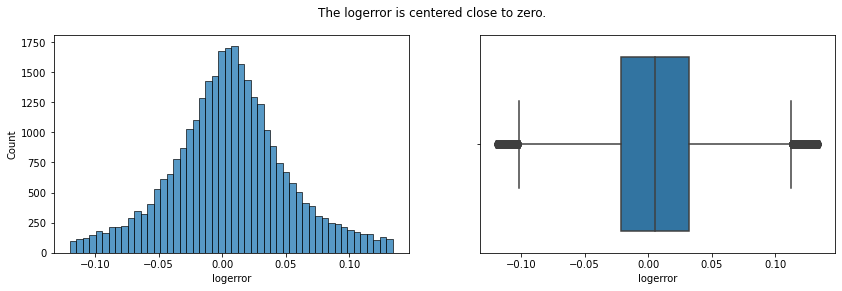

In [6]:
# Let's try removing outliers.
train_no_outliers = remove_outliers(train, 1.5, ['logerror'])
plot_single_variable(train_no_outliers, 'logerror', title = 'The logerror is centered close to zero.')

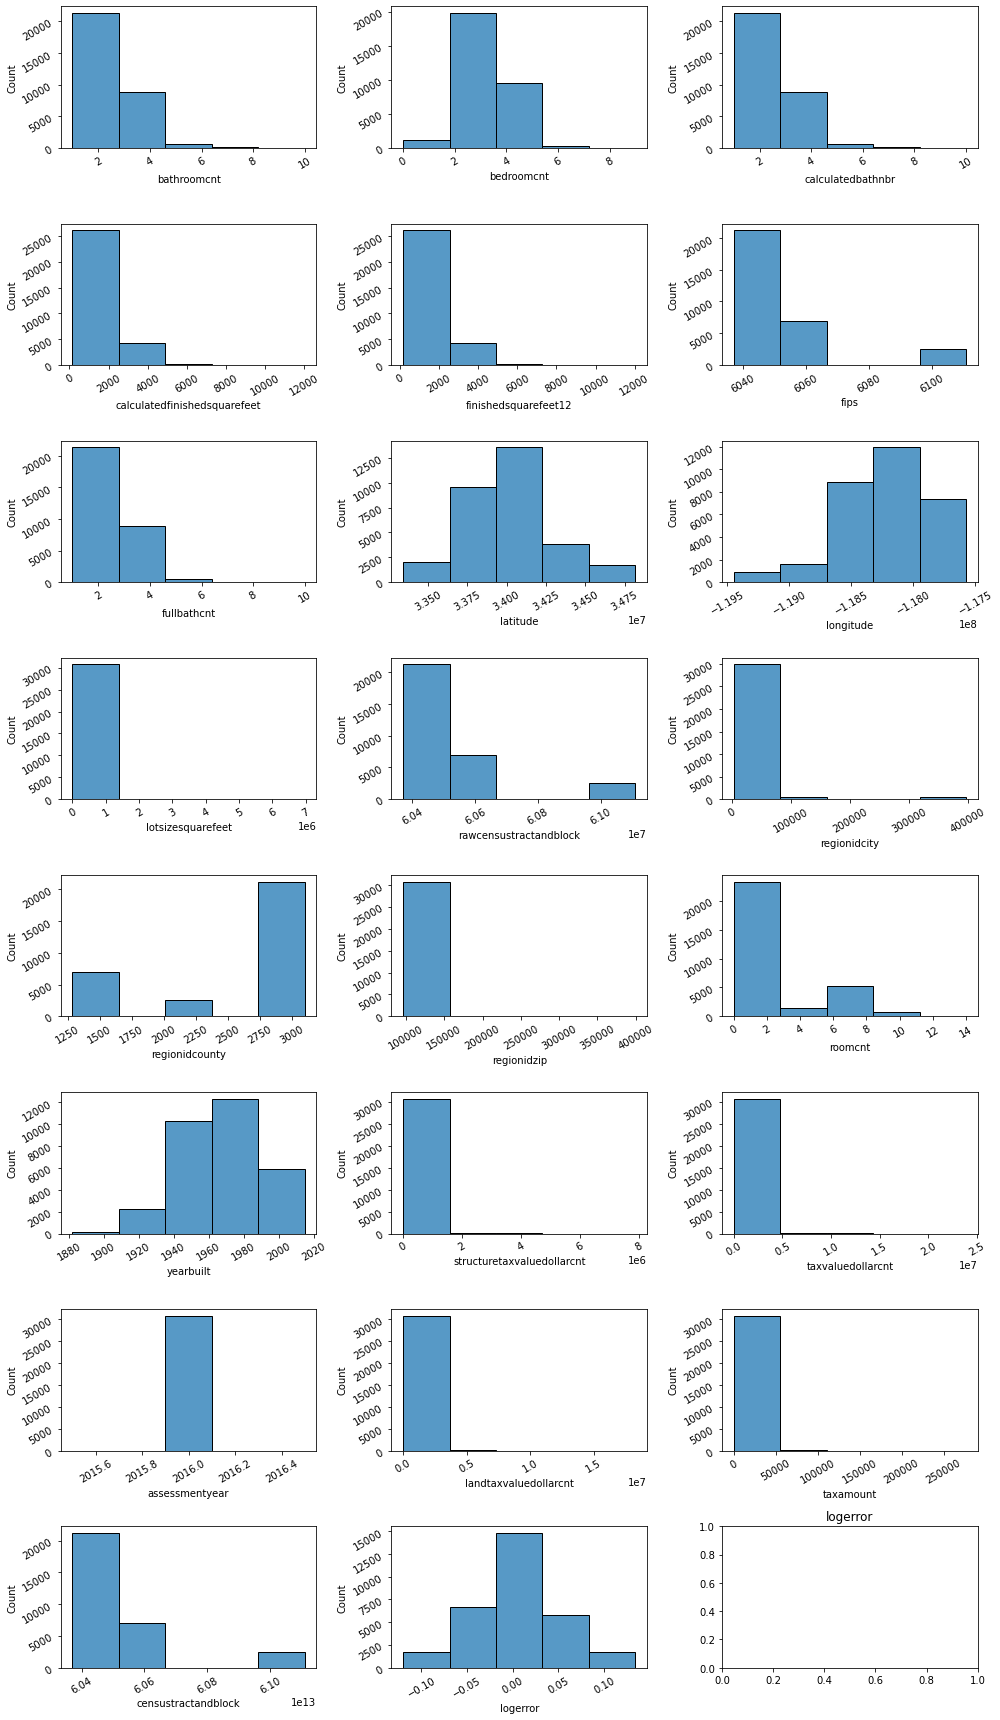

In [7]:
get_hist(train_no_outliers, train.select_dtypes(include = 'number').columns)

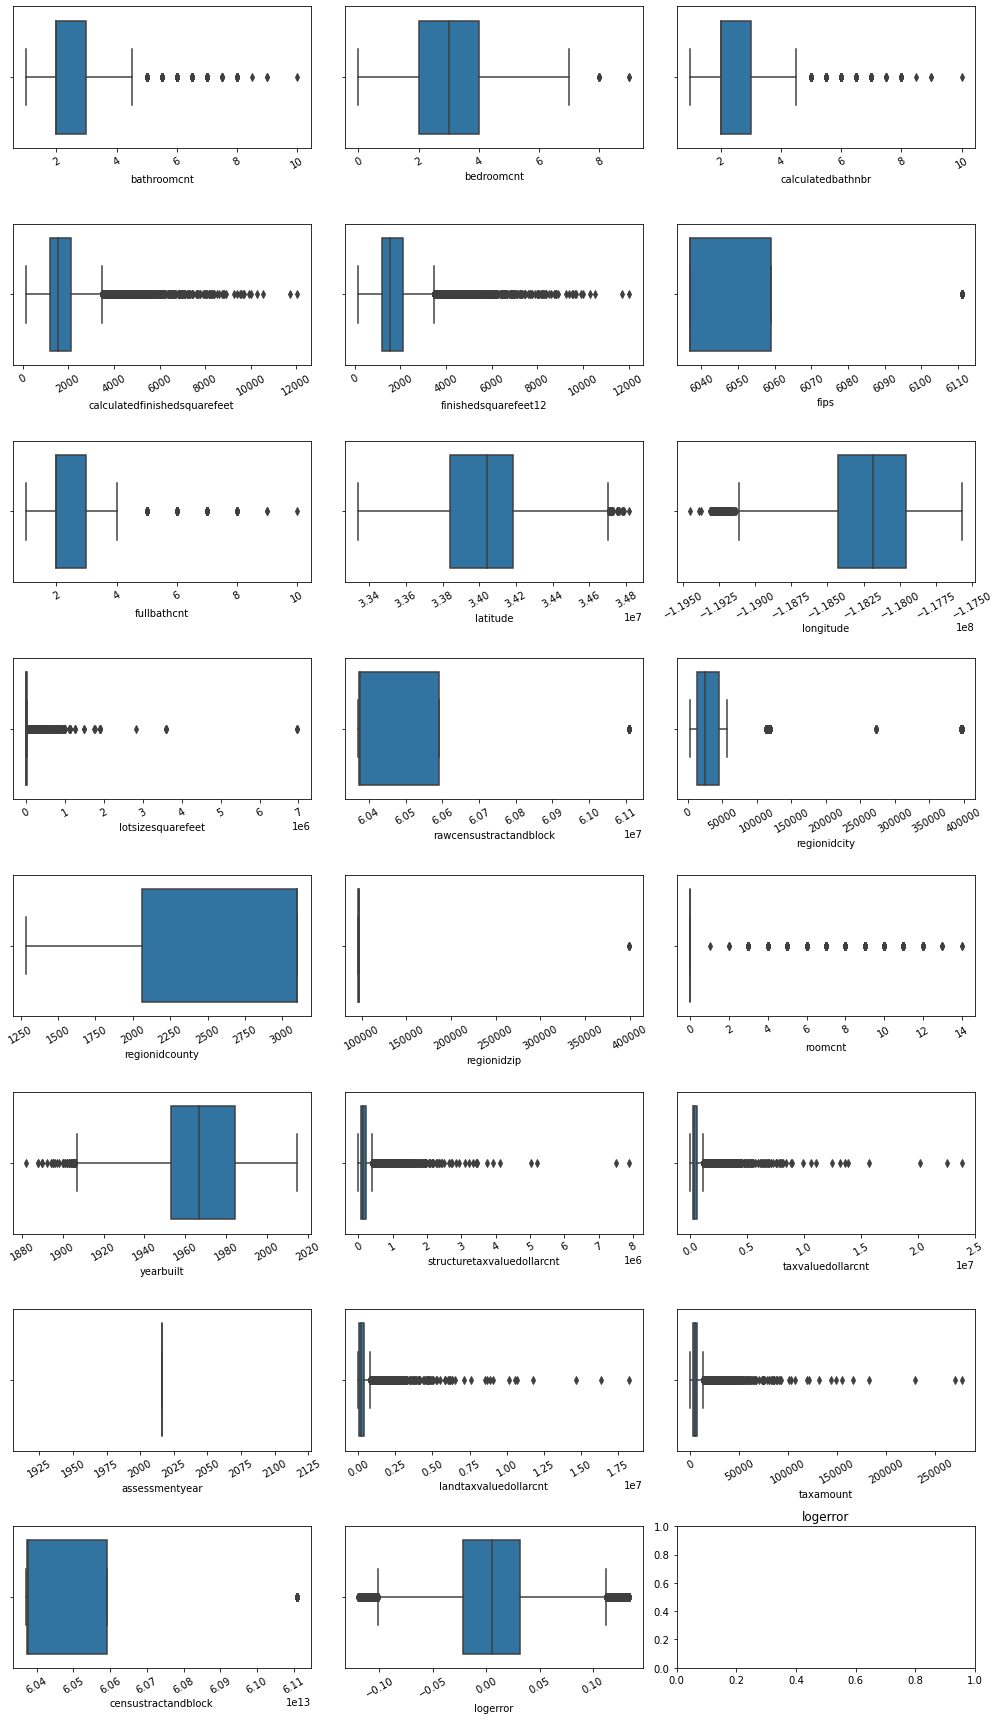

In [8]:
get_box(train_no_outliers, train.select_dtypes(include = 'number').columns)

Looks like some features have outliers. We'll keep this in mind going into modeling. For now we will move forward and answer the following questions:

- Does the age of the property relate to logerror?
- Does the zip code a property is located in relate to logerror?
- Does the square footage of a property relate to logerror?
- Does the bedroom and bathroom count relate to logerror?

---

## Bivariate Analysis

Let's answer our questions and look at how our variables interact with logerror.

### Does the age of the property relate to logerror?

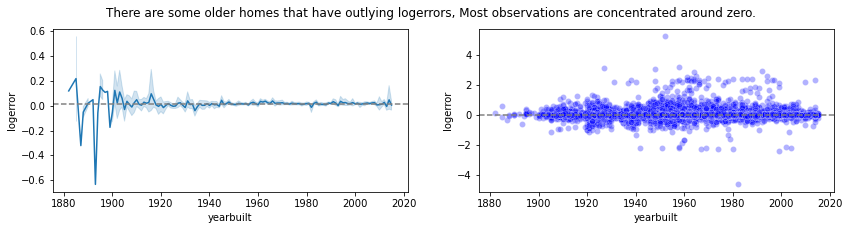

In [9]:
plot_continuous_and_continuous(
    train,
    'yearbuilt',
    'logerror',
    title = 'There are some older homes that have outlying logerrors, Most observations are concentrated around zero.'
)

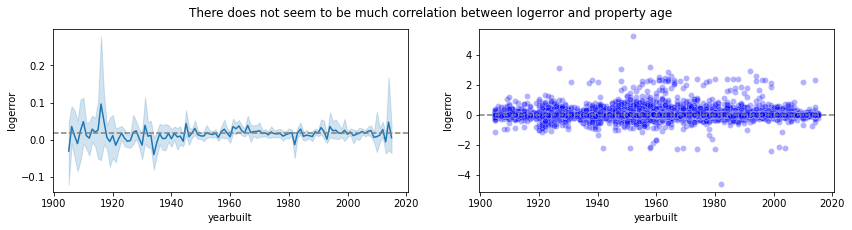

In [65]:
# Let's see it again without outliers.
plot_continuous_and_continuous(
    remove_outliers(train, 1.5, ['yearbuilt']),
    'yearbuilt',
    'logerror',
    title = 'There does not seem to be much correlation between logerror and property age'
)

### Does the zip code a property is located in relate to logerror?

In [11]:
train.regionidzip.value_counts()

97319.0    457
97318.0    387
97329.0    323
97328.0    321
97118.0    293
          ... 
96963.0      2
96039.0      2
96226.0      2
96973.0      2
96467.0      1
Name: regionidzip, Length: 381, dtype: int64

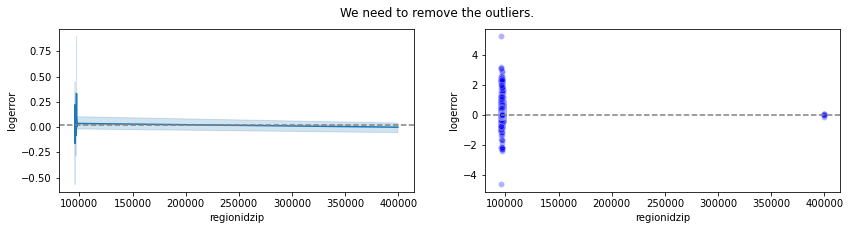

In [12]:
# Zip code is technically not continuous, but let's see what we get.
plot_continuous_and_continuous(
    train,
    'regionidzip',
    'logerror',
    title = 'We need to remove the outliers.'
)

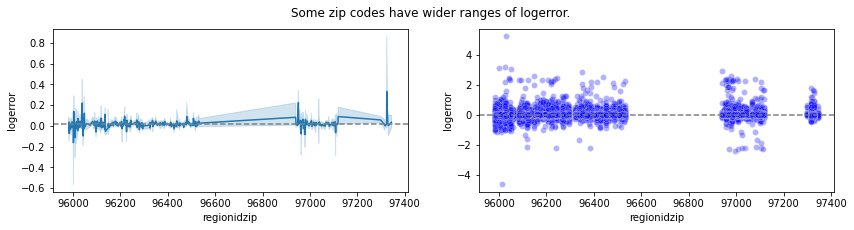

In [13]:
plot_continuous_and_continuous(
    remove_outliers(train, 1.5, ['regionidzip']),
    'regionidzip',
    'logerror',
    title = 'Some zip codes have wider ranges of logerror.'
)

It looks like there may be some zip codes that have greater discrepancy in logerror than others. Let's try running some statistical tests to determine if there is something there.

In [14]:
α = 0.05
zip_codes = []
mean_logerror = train.logerror.mean()

for zip_code in train.regionidzip.unique():
    mask = train.regionidzip == zip_code
    t, p = stats.ttest_1samp(train[mask].logerror, mean_logerror)
    
    if p < α:
        zip_codes.append(zip_code)
        
print(zip_codes)

[96095.0, 96985.0, 96522.0, 96045.0, 96415.0, 96152.0, 96190.0, 96974.0, 96289.0, 96026.0, 96517.0, 96280.0, 96201.0, 96336.0, 96212.0, 95997.0, 96029.0, 96271.0, 96123.0, 97298.0, 97026.0, 96006.0, 96294.0, 96508.0, 96437.0, 96047.0, 96507.0, 96217.0, 96426.0, 96514.0, 95989.0, 96020.0, 96022.0, 96326.0, 96127.0, 96005.0, 96120.0, 96379.0, 96234.0, 95984.0, 96016.0, 96240.0, 96017.0, 96103.0, 97084.0, 96097.0, 96137.0, 96043.0, 96136.0, 96134.0, 96216.0]


/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


There are quite a few zip codes where the mean logerror varies significantly from the overall mean logerror. Let's see if these zip codes have a reasonable amount of data points and not just 1 or 2 outliers.

In [15]:
train[train.isin(zip_codes)].value_counts()

Series([], dtype: int64)

In [16]:
train[train.regionidzip.isin(zip_codes)].regionidzip.value_counts()

96974.0    201
96379.0    174
97026.0    166
96212.0    155
96123.0    151
96190.0    150
96985.0    148
96522.0    147
96047.0    137
96415.0    130
96095.0    124
96026.0    123
96120.0    122
96045.0    120
96005.0    113
96507.0    112
96006.0    109
96426.0    108
96437.0    108
97084.0     99
96294.0     96
96271.0     93
95997.0     89
96127.0     83
96514.0     81
95984.0     77
96517.0     77
96029.0     72
96336.0     71
96020.0     70
96508.0     67
96240.0     67
96152.0     66
96289.0     66
96217.0     64
96022.0     61
96234.0     60
96016.0     60
96280.0     60
97298.0     59
96103.0     53
96134.0     51
95989.0     49
96017.0     47
96326.0     39
96201.0     36
96043.0     34
96137.0     25
96097.0     24
96216.0     20
96136.0     14
Name: regionidzip, dtype: int64

There are a few zip codes that don't have that many observations, but most of these zip codes do have enough observations for it to be reasonable to assume that the mean logerror being significantly different than the overall mean logerror is something worth looking at further.

### Does the square footage of a property relate to logerror?

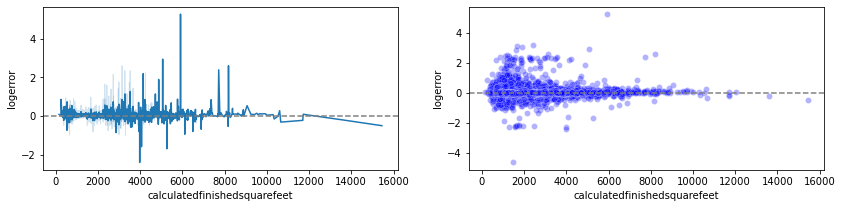

In [17]:
plot_continuous_and_continuous(train, 'calculatedfinishedsquarefeet', 'logerror')

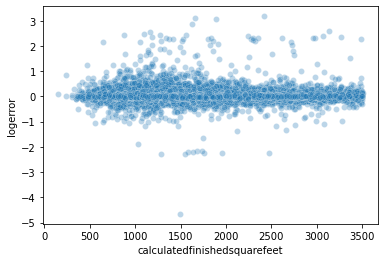

In [64]:
sns.scatterplot(
    data = remove_outliers(train, 1.5, ['calculatedfinishedsquarefeet']),
    x = 'calculatedfinishedsquarefeet',
    y = 'logerror',
    alpha = 0.3
);

It looks like a lot of smaller properties tend to have greater logerror. Let's try a statistical test see if the mean logerror for properties with less than 5000 square feet is significantly different than the overall mean logerror.

In [18]:
# H0: The mean logerror for properties with less than 5000 square feet is not significantly different than the 
# overall mean logerror.

mask = train.calculatedfinishedsquarefeet < 5000
t, p = stats.ttest_1samp(train[mask].logerror, mean_logerror)

if p < α:
    print('Reject H0')
else:
    print('Fail to reject H0')

Fail to reject H0


We fail to reject the null hypothesis, but let's try one more time and reduce the threshold to 4000.

In [19]:
# H0: The mean logerror for properties with less than 4000 square feet is not significantly different than the 
# overall mean logerror.

mask = train.calculatedfinishedsquarefeet < 4000
t, p = stats.ttest_1samp(train[mask].logerror, mean_logerror)

if p < α:
    print('Reject H0')
else:
    print('Fail to reject H0')

Fail to reject H0


Same result, but we'll see in multivariate exploration if the outlying values here may relate to other variables.

### Does the lot size relate to logerror?

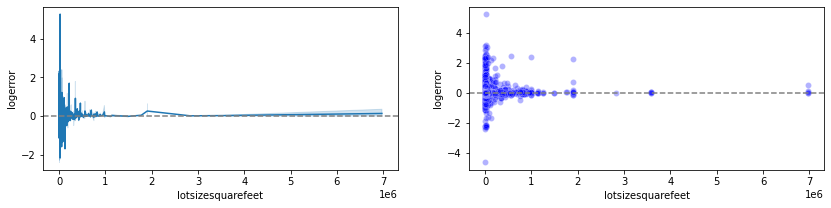

In [20]:
plot_continuous_and_continuous(train, 'lotsizesquarefeet', 'logerror')

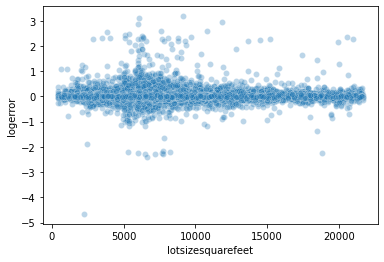

In [63]:
sns.scatterplot(
    data = remove_outliers(train, 1.5, ['lotsizesquarefeet']),
    x = 'lotsizesquarefeet',
    y = 'logerror',
    alpha = 0.3
);

### Does the bedroom and bathroom count relate to logerror?

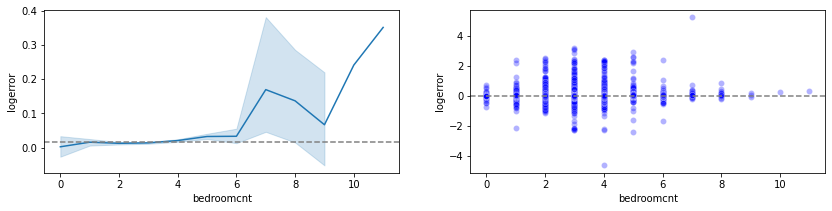

In [21]:
plot_continuous_and_continuous(train, 'bedroomcnt', 'logerror')

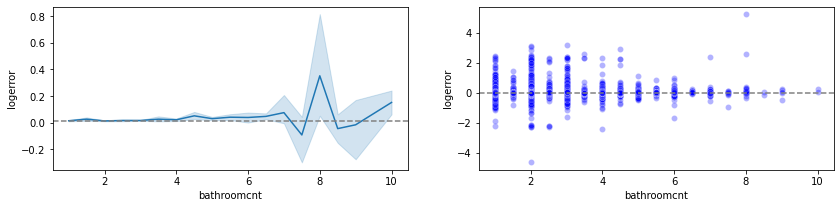

In [22]:
plot_continuous_and_continuous(train, 'bathroomcnt', 'logerror')

### Taxvaluedollarcnt

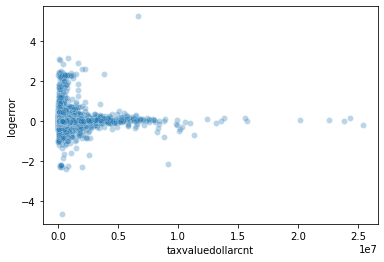

In [59]:
sns.scatterplot(
    data = train,
    x = 'taxvaluedollarcnt',
    y = 'logerror',
    alpha = 0.3
);

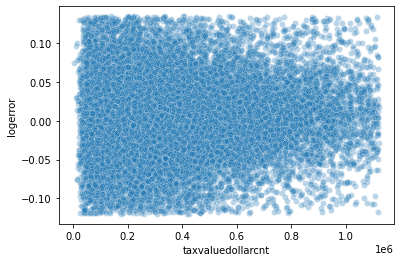

In [62]:
sns.scatterplot(
    data = remove_outliers(train, 1.5, ['logerror', 'taxvaluedollarcnt']),
    x = 'taxvaluedollarcnt',
    y = 'logerror',
    alpha = 0.3
);

---

## Multivariate Analysis

### Pairplot

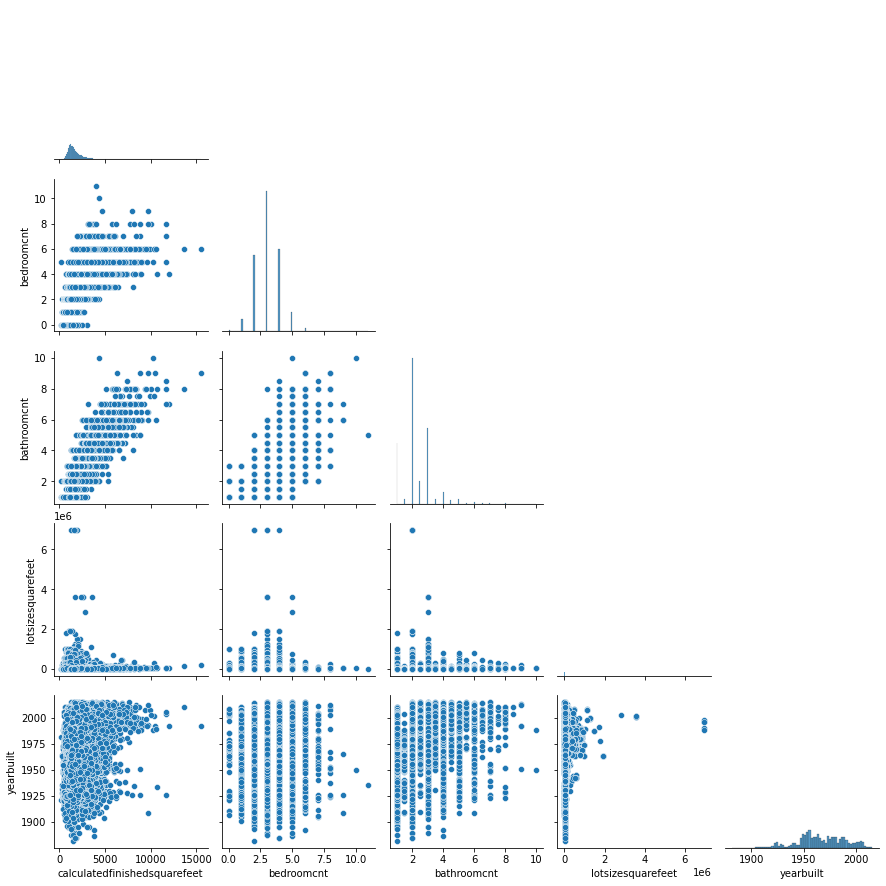

In [23]:
columns = [
    'calculatedfinishedsquarefeet',
    'bedroomcnt',
    'bathroomcnt',
    'lotsizesquarefeet',
    'yearbuilt'
]
sns.pairplot(data = train[columns], corner = True);

It looks like there may be some clusters between square feet and lot size, and lot size and property age.

### Lot size, square feet, and property age

In [24]:
# Let's put property age into bins
bins = [1800, 1925, 1950, 1975, 2000, 2020]
train['yearbuilt_binned'] = pd.cut(train['yearbuilt'], bins)
train.yearbuilt_binned.value_counts()

(1950, 1975]    14667
(1975, 2000]     9936
(1925, 1950]     5612
(2000, 2020]     2698
(1800, 1925]     1954
Name: yearbuilt_binned, dtype: int64

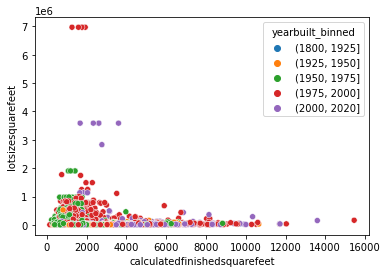

In [25]:
sns.scatterplot(data = train, x = 'calculatedfinishedsquarefeet', y = 'lotsizesquarefeet', hue = 'yearbuilt_binned');

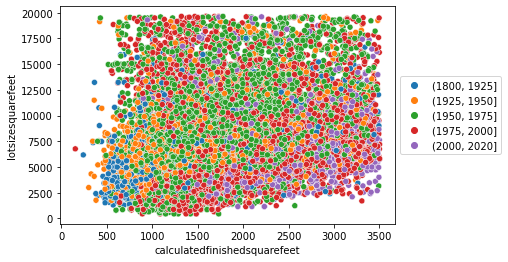

In [26]:
# Let's try removing outliers.
sns.scatterplot(
    data = remove_outliers(train, 1.5, ['calculatedfinishedsquarefeet', 'lotsizesquarefeet']),
    x = 'calculatedfinishedsquarefeet',
    y = 'lotsizesquarefeet',
    hue = 'yearbuilt_binned'
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

It's hard to see what's going on. Let's try separating the yearbuilt bins.

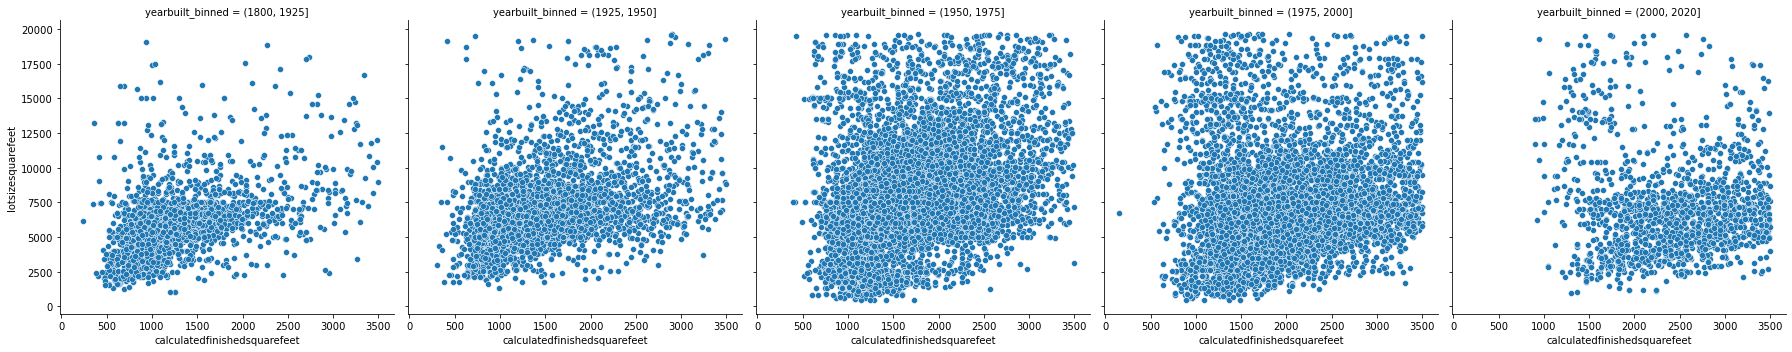

In [27]:
sns.relplot(
    data = remove_outliers(train, 1.5, ['calculatedfinishedsquarefeet', 'lotsizesquarefeet']),
    x = 'calculatedfinishedsquarefeet',
    y = 'lotsizesquarefeet',
    col = 'yearbuilt_binned'
);

There may be some clusters here. The older homes tend to be smaller and the newer homes tend to be larger.

## Clustering

Let's try building clusters using the lot size, square feet, and property age.

In [28]:
# First let's convert yearbuilt into property_age.
train['property_age'] = 2017 - train['yearbuilt']
train.property_age.describe()

count    34867.000000
mean        50.514068
std         22.499190
min          2.000000
25%         33.000000
50%         52.000000
75%         65.000000
max        135.000000
Name: property_age, dtype: float64

In [29]:
# Now let's scale the data using a MinMaxScaler
columns = [
    'property_age',
    'calculatedfinishedsquarefeet',
    'lotsizesquarefeet'
]

train_scaled = scale_data(train, columns = columns)

In [30]:
train_scaled[columns].describe()

property_age  calculatedfinishedsquarefeet  lotsizesquarefeet
count  34867.000000                  34867.000000       34867.000000
mean       0.364767                      0.106810           0.004292
std        0.169167                      0.060679           0.018695
min        0.000000                      0.000000           0.000000
25%        0.233083                      0.067983           0.000774
50%        0.375940                      0.090862           0.000983
75%        0.473684                      0.128448           0.001682
max        1.000000                      1.000000           1.000000

In [31]:
# Now let's import our clustering functions.
from clustering import *

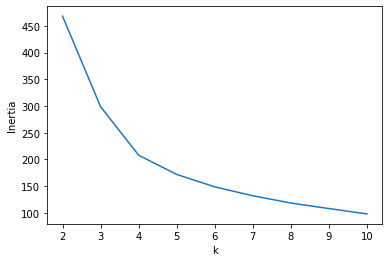

In [32]:
# Let's determine the best value of k to use.
plot_kmeans_inertia(train_scaled, columns, (2, 11))

It looks like 4 might be the elbow. We'll try 4 clusters.

In [50]:
train_scaled = create_clusters(train_scaled, columns, 4)

In [51]:
# Let's see if it worked.
train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34867 entries, 68462 to 5796
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   bathroomcnt                   34867 non-null  float64 
 1   bedroomcnt                    34867 non-null  float64 
 2   calculatedbathnbr             34867 non-null  float64 
 3   calculatedfinishedsquarefeet  34867 non-null  float64 
 4   finishedsquarefeet12          34867 non-null  float64 
 5   fips                          34867 non-null  float64 
 6   fullbathcnt                   34867 non-null  float64 
 7   latitude                      34867 non-null  float64 
 8   longitude                     34867 non-null  float64 
 9   lotsizesquarefeet             34867 non-null  float64 
 10  propertycountylandusecode     34867 non-null  object  
 11  rawcensustractandblock        34867 non-null  float64 
 12  regionidcity                  34867 non-nul

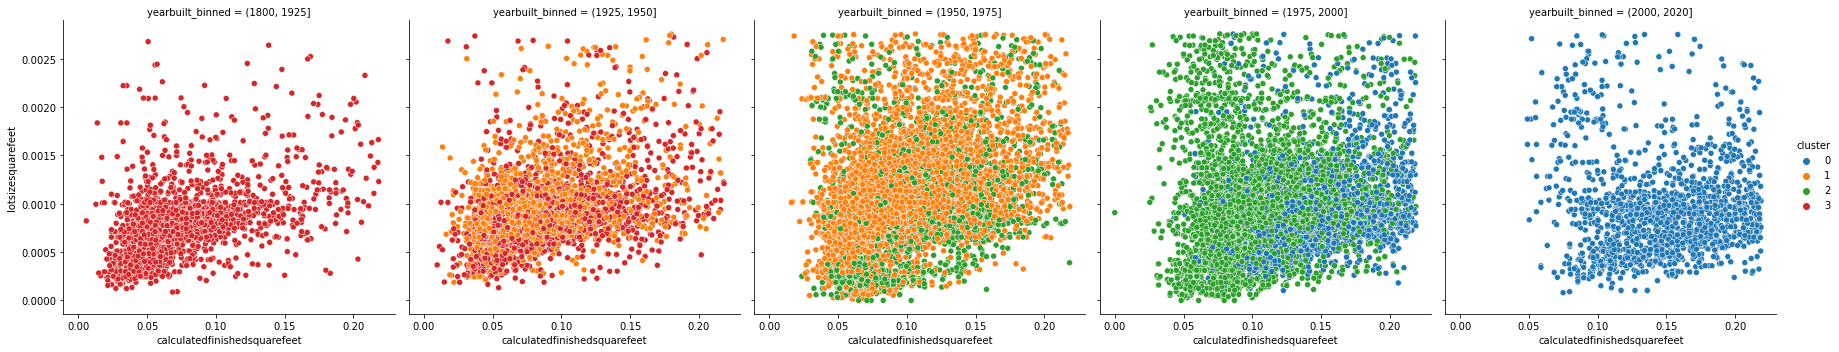

In [52]:
# Let's see the results.
sns.relplot(
    data = remove_outliers(train_scaled, 1.5, ['calculatedfinishedsquarefeet', 'lotsizesquarefeet']),
    x = 'calculatedfinishedsquarefeet',
    y = 'lotsizesquarefeet',
    col = 'yearbuilt_binned',
    hue = 'cluster'
);

In [53]:
train['cluster'] = train_scaled['cluster']

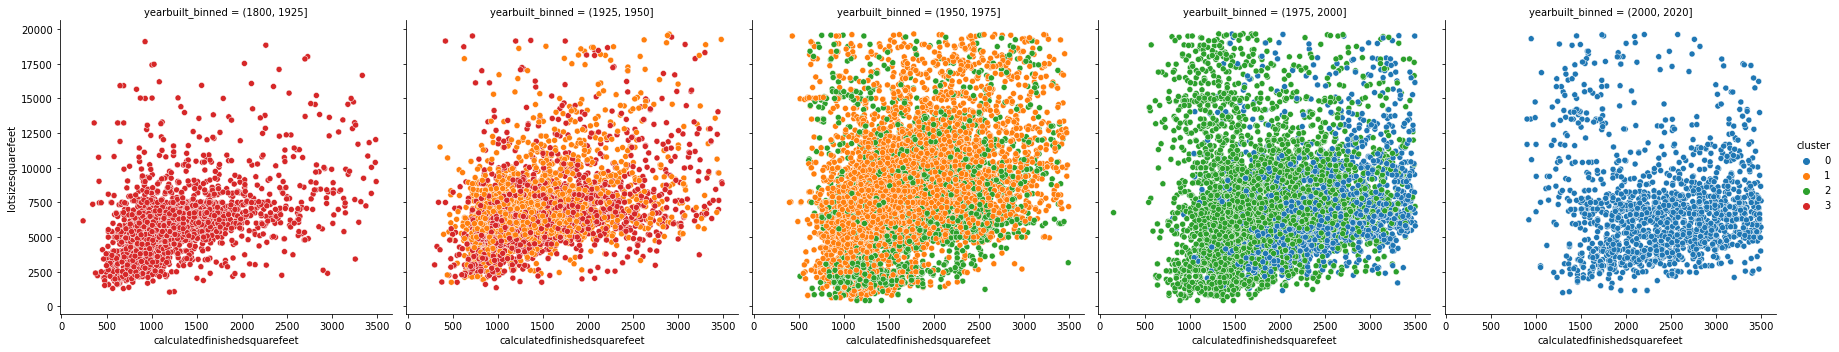

In [54]:
sns.relplot(
    data = remove_outliers(train, 1.5, ['calculatedfinishedsquarefeet', 'lotsizesquarefeet']),
    x = 'calculatedfinishedsquarefeet',
    y = 'lotsizesquarefeet',
    col = 'yearbuilt_binned',
    hue = 'cluster'
);

It looks like it mostly binned by property age.

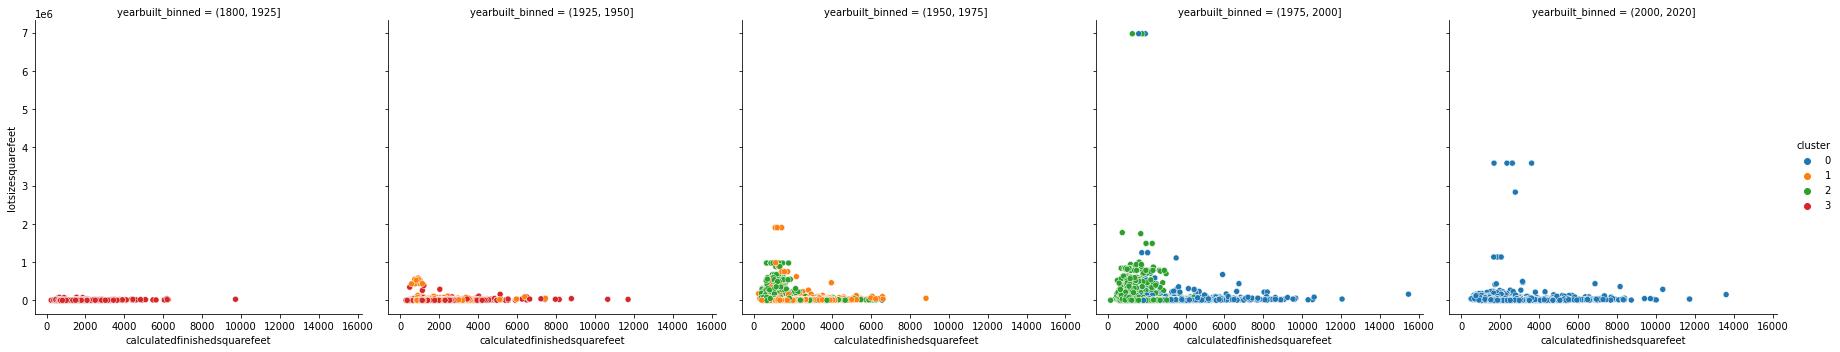

In [55]:
sns.relplot(
    data = train,
    x = 'calculatedfinishedsquarefeet',
    y = 'lotsizesquarefeet',
    col = 'yearbuilt_binned',
    hue = 'cluster'
);

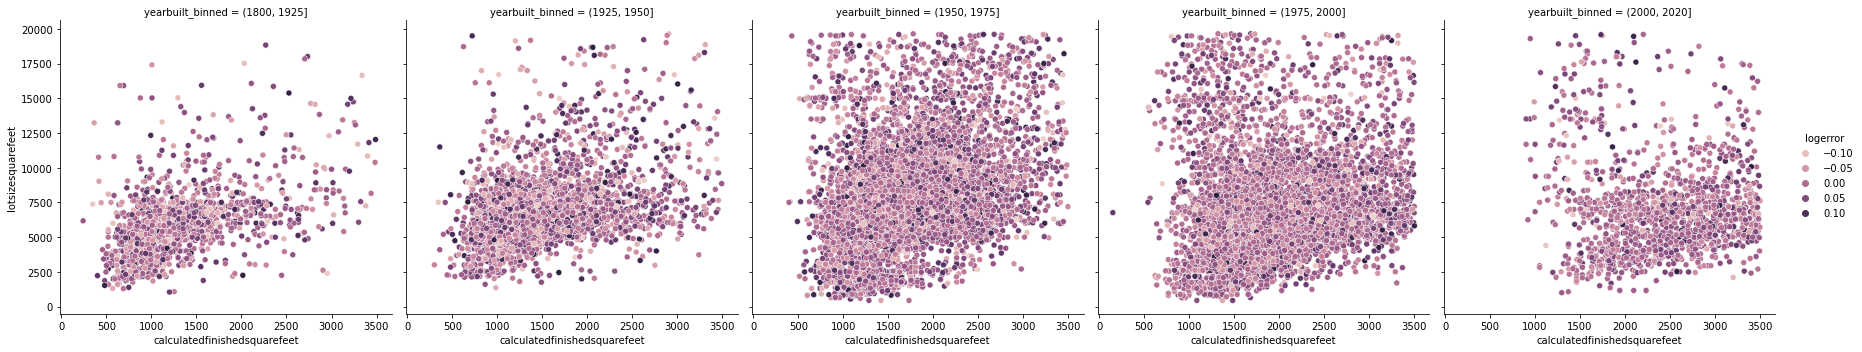

In [67]:
sns.relplot(
    data = remove_outliers(train, 1.5, ['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'logerror']),
    x = 'calculatedfinishedsquarefeet',
    y = 'lotsizesquarefeet',
    col = 'yearbuilt_binned',
    hue = 'logerror'
);

In [83]:
# Let's try binning logerror to see if we can get a clearer picture.
bins = [-10, -0.025, 0.025, 10]
train['logerror_binned'] = pd.cut(train['logerror'], bins)
train.logerror_binned.value_counts()

(-0.025, 0.025]    14413
(0.025, 10.0]      11820
(-10.0, -0.025]     8634
Name: logerror_binned, dtype: int64

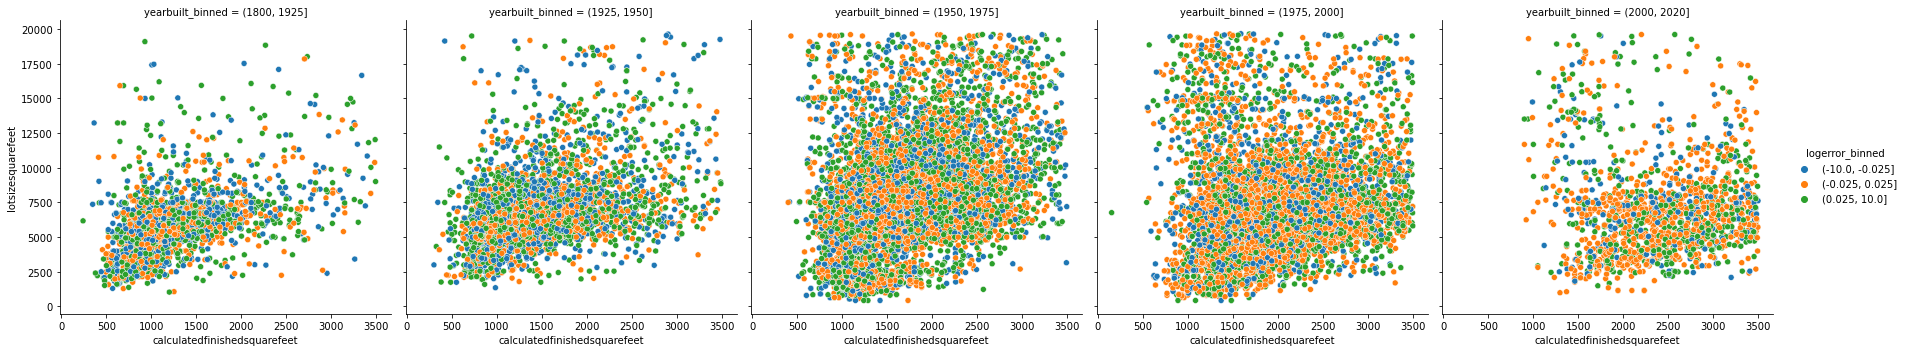

In [84]:
sns.relplot(
    data = remove_outliers(train, 1.5, ['calculatedfinishedsquarefeet', 'lotsizesquarefeet']),
    x = 'calculatedfinishedsquarefeet',
    y = 'lotsizesquarefeet',
    col = 'yearbuilt_binned',
    hue = 'logerror_binned'
);

In [97]:
train = pd.get_dummies(train, columns = ['cluster'])
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34867 entries, 68462 to 5796
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   bathroomcnt                   34867 non-null  float64 
 1   bedroomcnt                    34867 non-null  float64 
 2   calculatedbathnbr             34867 non-null  float64 
 3   calculatedfinishedsquarefeet  34867 non-null  float64 
 4   finishedsquarefeet12          34867 non-null  float64 
 5   fips                          34867 non-null  float64 
 6   fullbathcnt                   34867 non-null  float64 
 7   latitude                      34867 non-null  float64 
 8   longitude                     34867 non-null  float64 
 9   lotsizesquarefeet             34867 non-null  float64 
 10  propertycountylandusecode     34867 non-null  object  
 11  rawcensustractandblock        34867 non-null  float64 
 12  regionidcity                  34867 non-nul

## Zip Code Bins

In [94]:
train['is_in_non_average_zip_code'] = train.regionidzip.isin(zip_codes)
train.is_in_non_average_zip_code = train.is_in_non_average_zip_code.astype('int')
train.is_in_non_average_zip_code.value_counts()

0    30339
1     4528
Name: is_in_non_average_zip_code, dtype: int64

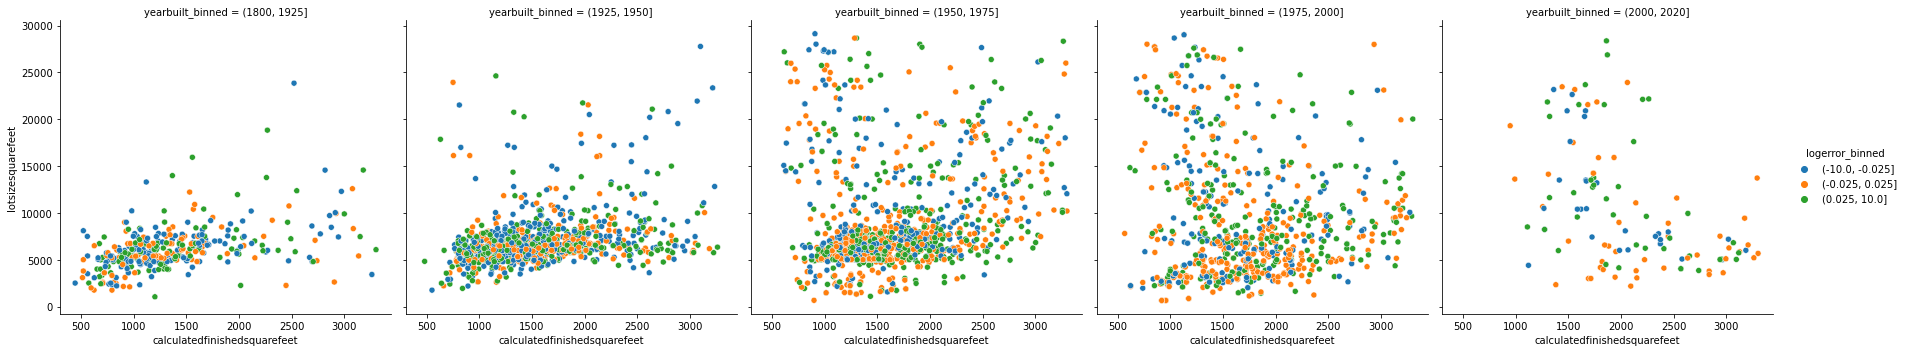

In [86]:
sns.relplot(
    data = remove_outliers(train[train.is_in_non_average_zip_code], 1.5, ['calculatedfinishedsquarefeet', 'lotsizesquarefeet']),
    x = 'calculatedfinishedsquarefeet',
    y = 'lotsizesquarefeet',
    col = 'yearbuilt_binned',
    hue = 'logerror_binned'
);

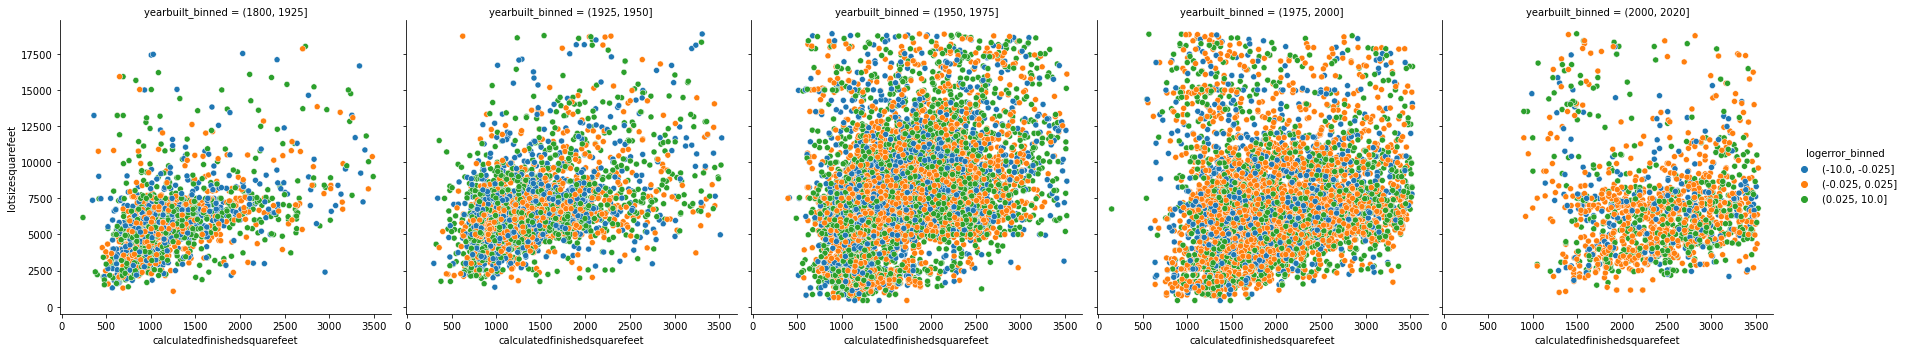

In [87]:
sns.relplot(
    data = remove_outliers(train[~train.is_in_non_average_zip_code], 1.5, ['calculatedfinishedsquarefeet', 'lotsizesquarefeet']),
    x = 'calculatedfinishedsquarefeet',
    y = 'lotsizesquarefeet',
    col = 'yearbuilt_binned',
    hue = 'logerror_binned'
);

## Visualizing logerror and clusters

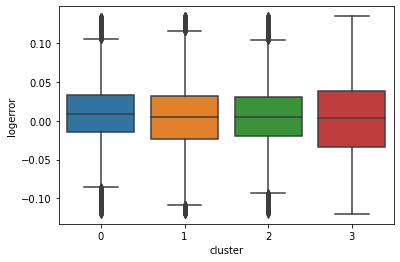

In [89]:
sns.boxplot(
    data = remove_outliers(train, 1.5, ['logerror']),
    x = 'cluster',
    y = 'logerror'
);

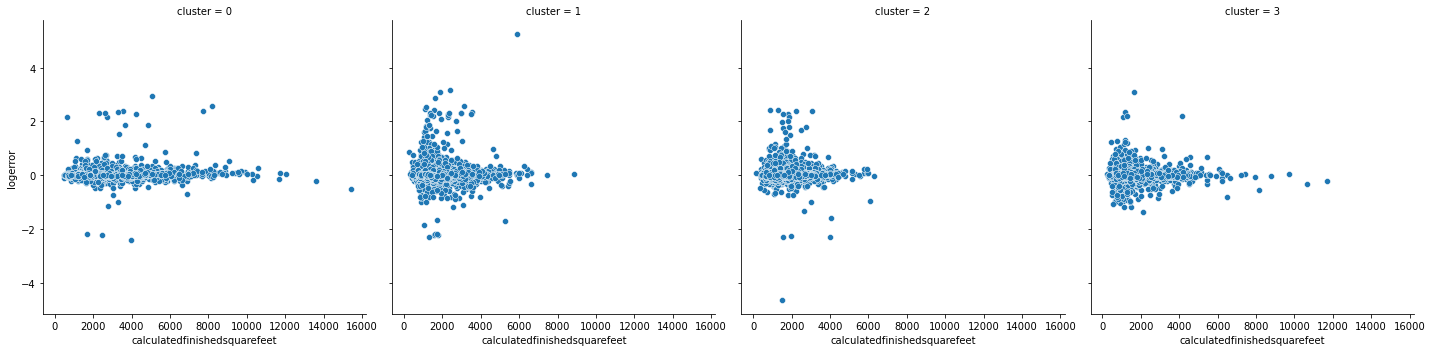

In [90]:
sns.relplot(
    data = train,
    x = 'calculatedfinishedsquarefeet',
    y = 'logerror',
    col = 'cluster'
);

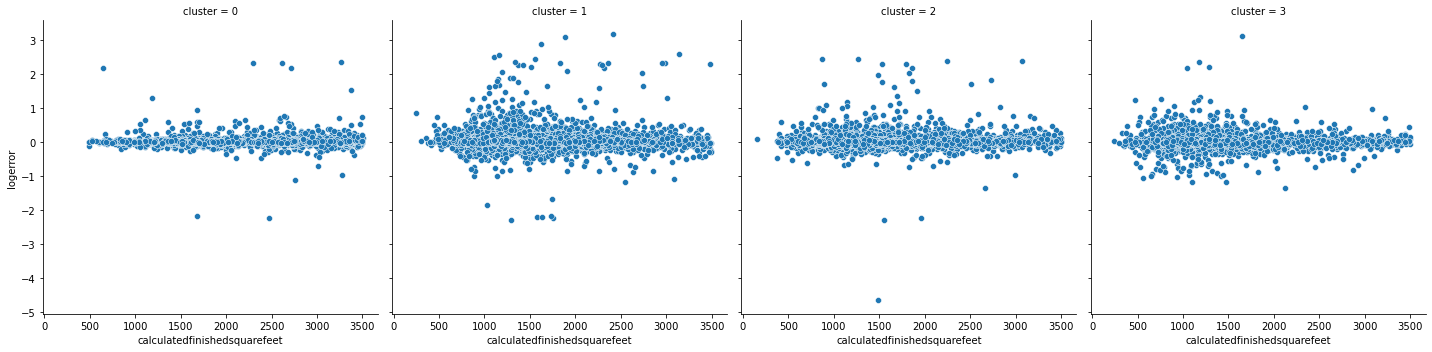

In [93]:
sns.relplot(
    data = remove_outliers(train, 1.5, ['calculatedfinishedsquarefeet']),
    x = 'calculatedfinishedsquarefeet',
    y = 'logerror',
    col = 'cluster'
);

## Takeaways

- There are significant differences in mean logerror for some zip codes.
- Clusters do not seem to make much difference, but we'll see what happens in modeling.
- There may be a small relationship between property size and logerror.